# GenAI-Camp: Day 03
## Lesson: RAG Evaluation

This lesson is intended to show you how to evaluate a RAG system.

During this lesson you will learn how to ...

- synthetically generate test data
- use metrics for evaluating the retrieval
- visually compare different configurations of the RAG system

### Set up the environment
Import the necessary libraries, set constants, and define helper functions.

In [1]:
from pydantic import BaseModel
import json
from google import genai
from google.genai import types
from time import sleep
import random
import os
import matplotlib.pyplot as plt
from enum import Enum


In [2]:
if os.getenv("COLAB_RELEASE_TAG"):
   from google.colab import userdata
   GOOGLE_API_KEY=userdata.get('GEMINI_API_KEY')
   COLAB = True
   print("Running on COLAB environment.")
else:
   from dotenv import load_dotenv, find_dotenv
   load_dotenv(find_dotenv())
   GOOGLE_API_KEY = os.getenv("GEMINI_API_KEY")
   COLAB = False
   print("WARNING: Running on LOCAL environment.")
client = genai.Client(api_key=GOOGLE_API_KEY)

In [ ]:
# Install additional libraries
if COLAB:
  !pip install -qU chromadb
    
# Import additional libraries
from chromadb import PersistentClient

In [4]:
# Define path of ressources
if COLAB:
    # Clone the data repository into colab
    !git clone https://github.com/openknowledge/workshop-genai-camp-data.git
    %cd workshop-genai-camp-data
    !git lfs pull 
    ROOT_PATH = "/content/workshop-genai-camp-data/day-03"
else:
    ROOT_PATH = ".."
DATA_PATH = ROOT_PATH + "/data"
EVALUATION_PATH = ROOT_PATH + "/evaluation"
KNOWLEDGEBASE_PATH = ROOT_PATH + "/knowledgebase"
BOOK_CATALOG_FILE = DATA_PATH + "/books.json"
TESTDATA_FILE = EVALUATION_PATH + "/synthetic_testset.json"

In [5]:
# Set default models
GENERATION_MODEL = "gemini-1.5-flash"
EMBEDDING_MODEL = "models/text-embedding-004"

# Set default values for model, model parameters and prompt
DEFAULT_CONFIG_TEMPERATURE = 0.9 
DEFAULT_CONFIG_TOP_K = 1
DEFAULT_CONFIG_MAX_OUTPUT_TOKENS = 200 
DEFAULT_SYSTEM_PROMPT = "Your are a friendly assistant"
DEFAULT_USER_PROMPT = " "

# Set defaults for rag
DEFAULT_K = 3
DEFAULT_CHUNK_SIZE = 2000
DEFAULT_CHUNK_OVERLAP = 100

In [ ]:
class MimeType(Enum):
    """
    Enum for MIME types.
    """
    JSON = "application/json"


class ResponseFormat(BaseModel):
    """
    Response format model for Gemini API.
    """
    response_mime_type: MimeType
    response_schema: type
    
   
def generate_gemini_completion(
        user_prompt : str,
        response_format: ResponseFormat | None = None,
        system_prompt: str = DEFAULT_SYSTEM_PROMPT,
        model_name: str = GENERATION_MODEL, 
        verbose: bool = False
        ) -> str: 
    """
    Call the GenAI model with function declarations and return the response.
    Args:
        user_prompt (str): The prompt to send to the model.
        response_format (ResponseFormat): The format of the response.
        system_prompt (str): The system prompt to use.
        model_name (str): The name of the model to use.
        verbose (bool): If True, print the response.
    Returns:
        str: The response from the model.
    """

    # Configure response format
    response_schema = None
    response_mime_type = None
    if response_format:
        response_schema = response_format.response_schema
        response_mime_type = response_format.response_mime_type.value

    config = types.GenerateContentConfig(
        system_instruction=system_prompt,
        response_schema=response_schema,
        response_mime_type=response_mime_type,
    )

    response = client.models.generate_content(
        model=model_name,
        contents=user_prompt,
        config=config,
    )
    
    if verbose:
        print(f"Response: {response}")
    
    return response.text

In [7]:
# Define a function to read objects from a JSON file
def read_objects_from_json(file_path: str, cls: BaseModel) -> list:
    """Reads list of objects from a JSON file and returns the list."""
    with open(file_path, 'r') as file:
        data = json.load(file)
        objects = [cls(**item) for item in data]
    return objects

# Define classes used in the ingestion process
class Metadata(BaseModel):
    """Represents the metadata of a document which is stored in the knowledgebase."""
    url: str
    title: str
    pub_year: int

class Book(BaseModel):
    """Represents a book with its metadata."""
    metadata: Metadata
    summary: str    

In [8]:
# RAG building blocks

# This will be the chromadb collection we use as a knowledge base. We do not need the client.
chromadb_collection = PersistentClient(path=KNOWLEDGEBASE_PATH).get_or_create_collection(name="default")

class FetchedChunk(BaseModel):
    """Represents a chunk fetched from the knowledgebase."""
    chunk: str
    metadata: Metadata

# Building Block "Embedding": Create multi dimensional embeddings for a given chunk.
def do_embed(chunk: str) -> list[float]:
  """ Embeds a given chunk and returns the embedding

  Parameters
  ----------
  chunk : str
      The chunk to be embedded
  Returns
  -------
  embedding: [float]
      The created embedding
  """
  content_embeddings = client.models.embed_content(model=EMBEDDING_MODEL, contents=chunk).embeddings
  return content_embeddings[0].values


# Building Block "Augmentation": Create an updated prompt by merging the original user input with the provided context
# Attention: We manipulated the augmented prompt in order to see the guardrails in action
def augment(user_input: str, context: list[str]) -> str:
  """ Augments a given user input by merging it with the provided context and returns the augmented prompt

  Parameters
  ----------
  user_input : str
      The user input to be augmented
  context : [str]
      The context to be merged with the user input
  Returns
  -------
  augmented_prompt: str
      The created augmented prompt
  """
  prepared_context = "\n".join(context)
  augmented_prompt = f"""
    Answer the question as detailed as possible from the provided context, make sure to provide all the details, if the answer is not in
    provided context just say, "answer is not available in the context", don't provide the wrong answer\n\n
    Context:\n{prepared_context}?\n
    Question: \n{user_input}\n

    Answer:
  """
  return augmented_prompt

# Building Block "Top-k Fetching": Get the k semantically closest chunks to the user input from the knowledgebase
def do_top_k_fetching(user_input_embedding: list[float], top_k: int) -> list[FetchedChunk]:
  """ Fetches the k semantically closest chunks to the user input from the knowledgebase

  Parameters
  ----------
  user_input_embedding : [float]
      The embedding of the user input
  top_k : int
      The number of semantically closest chunks to be fetched

  Returns
  -------
  context: [str]
      The fetched chunks
  """
  # Since we will do the fetching always only for one user_input,
  # instead of querying for multiple embeddings simultanously as allowed by the choma API,
  # we add the embeddings below to a list and return only the first document (chunk)
  
  query_result = chromadb_collection.query(
      query_embeddings=[user_input_embedding],
      n_results=top_k,
  )
  chunks = query_result["documents"][0]
  metadatas = query_result["metadatas"][0]
  
  fetched_chunks = []
  for i in range(len(chunks)):
    chunk = chunks[i]
    metadata = metadatas[i]
    fetched_chunk = FetchedChunk(chunk=chunk, metadata=Metadata(**metadata))
    fetched_chunks.append(fetched_chunk)
  return fetched_chunks

# Building Block "Generation": Use the generation model to create a response
def generate_response(prompt: str) -> str:
  """ Generates a response for a given prompt

  Parameters
  ----------
  prompt : str
      The prompt to be used for the generation
  Returns
  -------
  response: str
      The generated response
  """
  return generate_gemini_completion(
      model_name=GENERATION_MODEL,
      user_prompt=prompt,
  )

# The rag function should now return the response and the context in order to be evaluated further
def do_rag(user_input: str, top_k: int, retrieval_only: bool = False) -> tuple[str, list[str]]:
  """ Runs the RAG pipeline with a given user input and returns the response and the context

  Parameters
  ----------
  user_input : str
      The user input to be used for the RAG pipeline
  Returns
  -------
  response: str
      The generated response
  context: [str]
      The fetched chunks
  """
  # Embed the user input
  user_input_embedding = do_embed(chunk=user_input)

  # "R" like "Retrieval": Get the k semantically closest chunks to the user input from the knowledgebase
  fetched_chunks = do_top_k_fetching(user_input_embedding=user_input_embedding, top_k=top_k)
  context = [chunk.chunk for chunk in fetched_chunks]

  # "A" like "Augmented": Create the augmented prompt
  augmented_prompt = augment(user_input=user_input, context=context)

  # "G" like "Generation": Generate a response
  if not retrieval_only:
    # Generate a response using the augmented prompt
    response = generate_response(prompt=augmented_prompt)
  else:
    response = "No response generated. Only retrieval was requested."

  return (response, fetched_chunks)

### Exercise 01: Synthetic Testset
RAG evaluation is key for high performing genai systems. First priority should be to gather testsets from human experts. Additionally, it is possible to create a synthetic testset.  
In this exercise you will create a synthetic testset using genai. For this, use your prompt engineering skills to generate interactions from possible customers with bookstore employees. The customer should ask for a book by recalling some details of the specific book without mentioning the title. The employee should respond with the respective book title. Here is a possible interaction:  

**Customer**: *"I’m looking for an old book about a scientist who creates a creature out of dead body parts! The creature comes to life and things go very badly."*  

**Employee**: *"You’re talking about Frankenstein; or, The Modern Prometheus by Mary Shelley. The scientist is named Victor Frankenstein, and the creature doesn’t actually have a name, though people often mix them up."*
  
Your task is to provide the system prompt, which should lead to the generation of a possible customer question.  
In addition, you should provide the prompt, which adds the neccessary information to the generation of the employee response. Analyse the resulting interactions and improve your prompts based on that.

In [ ]:
# This should be one interaction between the user and the employee.
class TestdataItem(BaseModel):
    """Represents a test data item with its input, output, and source."""
    input: str  # Customer's question
    output: str # Employee's response
    source: Book # Book which the employee remembers the answer from

In [ ]:
# TODO: Use your prompt engineering skills to create a system prompt for generating possible customer questions.
# Define the role of the assistant as an assistant for test data generation.
# Give context: The assistant will be provided with a summary of a book.
# Define the task: The assistant should pretend to be a customer in a book store, who looks for the book described by the given summary.
# Define the output: The customer should vaguely remember key points of the book, but not the finer details and not the title.
# Provide an example of the CONTEXT and CUSTOMER. For this, use the CONTEXT and CUSTOMER part from the prompt below.
GEMINI_CUSTOMER_SYSTEM_PROMPT = \
    "You are an assistant for test data generation. " \
    "For this, you will be provided with a summary of a book. " \
    "Your task is to pretend to be a customer in a book store, who looks for the book described by the given summary." \
    "The customer should vaguely remember key points of the book, but not the finer details and not the title." \
    "You should just provide, what the customer would say. The customer using a maximum number of two sentences." \
    "Here is an Example:" \
    "SUMMARY: \"Frankenstein; Or, The Modern Prometheus\" by Mary Wollstonecraft Shelley is a novel written in the early 19th century. The story explores themes of ambition, the quest for knowledge, and the consequences of man's hubris through the experiences of Victor Frankenstein and the monstrous creation of his own making.   The opening of the book introduces Robert Walton, an ambitious explorer on a quest to discover new lands and knowledge in the icy regions of the Arctic. In his letters to his sister Margaret, he expresses both enthusiasm and the fear of isolation in his grand venture. As Walton's expedition progresses, he encounters a mysterious, emaciated stranger who has faced great suffering—furthering the intrigue of his narrative. This stranger ultimately reveals his tale of creation, loss, and the profound consequences of seeking knowledge that lies beyond human bounds. The narrative is set up in a manner that suggests a deep examination of the emotions and ethical dilemmas faced by those who dare to defy the natural order. (This is an automatically generated summary.)\"" \
    "CUSTOMER: I’m looking for an old book about a scientist who creates a creature out of dead body parts! The creature comes to life and things go very badly."

# This is the system prompt for generating the employee response.
GEMINI_BOOKSTORE_EMPLOYEE_SYSTEM_PROMPT = \
    "You are a book store employee. You are talking to a customer, who is looking for a book. " \
    "The customer is not sure about the title, but remembers some details from the book. " \
    "You should just provide, how the book store employee would respond. " \
    "The employee should only use the book described in the CONTEXT to answer the customer. " \
    "The employee should always name the title of the book and respond in a maximum number of two sentences." \
    "Here is an Example:" \
    "CUSTOMER: I’m looking for an old book about a scientist who creates a creature out of dead body parts? The creature comes to life and things go very badly." \
    "CONTEXT: \"Frankenstein; Or, The Modern Prometheus\" by Mary Wollstonecraft Shelley is a novel written in the early 19th century. The story explores themes of ambition, the quest for knowledge, and the consequences of man's hubris through the experiences of Victor Frankenstein and the monstrous creation of his own making.   The opening of the book introduces Robert Walton, an ambitious explorer on a quest to discover new lands and knowledge in the icy regions of the Arctic. In his letters to his sister Margaret, he expresses both enthusiasm and the fear of isolation in his grand venture. As Walton's expedition progresses, he encounters a mysterious, emaciated stranger who has faced great suffering—furthering the intrigue of his narrative. This stranger ultimately reveals his tale of creation, loss, and the profound consequences of seeking knowledge that lies beyond human bounds. The narrative is set up in a manner that suggests a deep examination of the emotions and ethical dilemmas faced by those who dare to defy the natural order. (This is an automatically generated summary.)\"" \
    "BOOK STORE EMPLOYEE: You’re talking about Frankenstein; or, The Modern Prometheus by Mary Shelley. The scientist is named Victor Frankenstein, and the creature doesn’t actually have a name, though people often mix them up. "

In [11]:
# Define response formats for the customer question and the bookstore employee response
class CustomerQuestion(BaseModel):
    """Defines the question of a customer looking for a book."""
    customer_question: str

class BookstoreEmployeeResponse(BaseModel):
    """Defines the response of a bookstore employee to a customer question."""
    employee_response: str

response_format_customer_question = ResponseFormat(
    response_mime_type=MimeType.JSON,
    response_schema=CustomerQuestion
)

response_format_bookstore_employee_response = ResponseFormat(
    response_mime_type=MimeType.JSON,
    response_schema=BookstoreEmployeeResponse
)

In [ ]:
# Set the number of test data items to be generated. Since this is only for demonstration purposes, we will only generate a few items.
n_testset_items = 2

# Get some random books from the book catalog and generate test data items
books = read_objects_from_json(file_path=BOOK_CATALOG_FILE, cls=Book)
random.shuffle(books)

# List for storing the test data items
testdata_items: list[TestdataItem] = []

for book in books:
    # Define the input prompt for the customer question, generate response and validate it
    input_prompt = f"SUMMARY: {book.summary}\nCUSTOMER:"
    customer_input_response = generate_gemini_completion(system_prompt=GEMINI_CUSTOMER_SYSTEM_PROMPT, user_prompt=input_prompt, response_format=response_format_customer_question)
    customer_input = CustomerQuestion(**json.loads(customer_input_response))

    # TODO: Define the employee prompt. Look at the example above for formatting.
    # Look and at the system prompt for the employee for what variables should be provided to the prompt.
    employee_prompt = f"CUSTOMER: {customer_input}\nCONTEXT: {book.summary}\nBOOK STORE EMPLOYEE:"
    employee_output_response = generate_gemini_completion(system_prompt=GEMINI_BOOKSTORE_EMPLOYEE_SYSTEM_PROMPT, user_prompt=employee_prompt, response_format=response_format_bookstore_employee_response)
    employee_output = BookstoreEmployeeResponse(**json.loads(employee_output_response))
    
    # Create a test data item and add it to the list
    testdata_item = TestdataItem(
        input=customer_input.customer_question,
        output=employee_output.employee_response,
        source=book
    )
    testdata_items.append(testdata_item)

    # Check if we have reached the desired number of test data items
    if len(testdata_items) >= n_testset_items:
        break

testdata_items

[TestdataItem(input='I am looking for an old book about the nature of reality.  The author argued that things only exist when perceived.', output='That sounds like "A Treatise Concerning the Principles of Human Knowledge" by George Berkeley.  He argues that things only exist when they are perceived.', source=Book(metadata=Metadata(url='https://www.gutenberg.org/ebooks/4723', title='A Treatise Concerning the Principles of Human Knowledge', pub_year=2003), summary='"A Treatise Concerning the Principles of Human Knowledge" by George Berkeley is a philosophical treatise written in the early 18th century. The work explores the foundations of human knowledge, particularly questioning the nature of existence and the perceivable reality, focusing on ideas and their connection to the perceiving mind.  The opening of the treatise sets the stage for Berkeley\'s inquiry into the principles of human knowledge, highlighting the contradictions and difficulties that arise from traditional philosophica

### Exercise 02: Evaluate the system
Your task is to implement another metric:  
1. **Precision**: Precision at K is the ratio of correctly identified relevant items within the total recommended items inside the K-long list. Simply put, it shows how many ground truth elements are included in the retrieved documents.

See [here](https://www.evidentlyai.com/ranking-metrics/precision-recall-at-k) for more information.

In [19]:
# Load generated test data items
testdata_items = read_objects_from_json(file_path=TESTDATA_FILE, cls=TestdataItem)

In [28]:
# Function to calculate the hit rate. 
def calculate_hit_rate(ground_truth, retrieved: list[str]):
    gt_set = set(ground_truth)
    retrieved_set = set(retrieved)
    return int(bool(gt_set & retrieved_set))

In [29]:
# Function to calculate the calculate_reciprocal_rank. 
def calculate_reciprocal_rank(ground_truth: list[str], retrieved: list[str]) -> float:
    gt_set = set(ground_truth)
    for rank, item in enumerate(retrieved, start=1):
        if item in gt_set:
            return 1 / rank
    return 0.0

In [ ]:
# TODO: Implement the function to calculate the precision.
def calculate_precision(ground_truth: list[str], retrieved: list[str]) -> float:

    # TODO: Get the number (length) of retrieved items
    k = len(retrieved)

    # Elements, which are present in both lists
    relevant_items_in_retrieved = (set(ground_truth) & set(retrieved))

    # TODO: Return the number of relevant items (ground truth) in the retrieved list divided by the number of retrieved items
    return len(relevant_items_in_retrieved) / k

In [34]:
# Test the metric functions
ground_truth = ["The Adventures of Tom Sawyer"]
retrieved = ["Huckleberry Finn", "The Adventures of Tom Sawyer", "The Great Gatsby"]

assert calculate_precision(ground_truth, retrieved) == 1/3
assert calculate_reciprocal_rank(ground_truth, retrieved) == 1/2
assert calculate_hit_rate(ground_truth, retrieved) == 1.0

In [23]:
# Run evaluation
# In a real-world scenario, you would use a larger test set and more sophisticated evaluation metrics.
# Here, we only evaluate the retrieval, since this is crucial for the RAG pipeline and does not necessarily depend on a generation model.
# For this example, we will just use the hit rate, reciprocal rank, and precision.

# Initialize lists to store the metrics
hit_rates = []
reciprocal_ranks = []
precisions = []

# Set the number of top k items to be retrieved
top_k = 3

# Iterate over the test data items
for testdata_item in testdata_items:

    # Prepare the ground truth
    ground_truth = [testdata_item.source.metadata.title]

    # Run the RAG pipeline. We only need the retrieval part for evaluation.
    response, fetched_chunks = do_rag(user_input=testdata_item.input, top_k=top_k, retrieval_only=True)

    # Check if the ground truth is in the context
    retrieved = [item.metadata.title for item in fetched_chunks]

    # Calculate metrics
    # Hit rate
    hit_rate_value = calculate_hit_rate(ground_truth=ground_truth, retrieved=retrieved)
    hit_rates.append(hit_rate_value)
    
    # Reciprocal rank
    reciprocal_rank = calculate_reciprocal_rank(ground_truth=ground_truth, retrieved=retrieved)
    reciprocal_ranks.append(reciprocal_rank)

    # Precision
    precision = calculate_precision(ground_truth=ground_truth, retrieved=retrieved)
    precisions.append(precision)

mean_hit_rate = sum(hit_rates) / len(hit_rates)
print(f"Mean hit rate: {mean_hit_rate:.2f}")

mean_reciprocal_rank = sum(reciprocal_ranks) / len(reciprocal_ranks)
print(f"Mean reciprocal rank: {mean_reciprocal_rank:.2f}")

mean_precision = sum(precisions) / len(precisions)
print(f"Mean precision: {mean_precision:.2f}")

Mean hit rate: 0.83
Mean reciprocal rank: 0.69
Mean precision: 0.28


### Exercise 03: Visualize performance of different configurations
In this exercise you should visualize the metrics above for different *top_k* and interpret the results. Create a [plot](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.plot.html), showing the values for Mean Hit Rate, MRR and Mean Precision for *k* ranging from 1 to 10.  


In [35]:
# Model for storing the evaluation result
class EvaluationResult(BaseModel):
    """Represents the evaluation result with its metrics."""
    mean_hit_rate: float
    mean_reciprocal_rank: float
    mean_precision: float

# Function to run the evaluation and return the metrics
def run_evaluation(top_k: int) -> EvaluationResult:
    hit_rates = []
    reciprocal_ranks = []
    precisions = []

    for testdata_item in testdata_items:

        # Prepare the ground truth
        ground_truth = [testdata_item.source.metadata.title]

        # Run the RAG pipeline
        _, fetched_chunks = do_rag(user_input=testdata_item.input, top_k=top_k, retrieval_only=True)

        # Check if the ground truth is in the context
        retrieved = [item.metadata.title for item in fetched_chunks]

        # Calculate metrics
        # Hit rate
        hit_rate_value = calculate_hit_rate(ground_truth=ground_truth, retrieved=retrieved)
        hit_rates.append(hit_rate_value)
        
        # Reciprocal rank
        reciprocal_rank = calculate_reciprocal_rank(ground_truth=ground_truth, retrieved=retrieved)
        reciprocal_ranks.append(reciprocal_rank)

        # Precision
        precision = calculate_precision(ground_truth=ground_truth, retrieved=retrieved)
        precisions.append(precision)
    
    # Calculate mean values
    mean_hit_rate = sum(hit_rates) / len(hit_rates)
    mean_reciprocal_rank = sum(reciprocal_ranks) / len(reciprocal_ranks)
    mean_precision = sum(precisions) / len(precisions)
    return EvaluationResult(
        mean_hit_rate=mean_hit_rate,
        mean_reciprocal_rank=mean_reciprocal_rank,
        mean_precision=mean_precision
    )

In [ ]:
# Run evaluation for k=1 to k=10 with a step of 2 (to speed up the process for demonstration purposes)
# This takes approximately 3.5 minutes.
k_values = list(range(1, 11,2))

# Initialize lists to store results
mean_hit_rates = []
mean_reciprocal_ranks = []
mean_precisions = []

# Iterate over the k values and run the evaluation
for k in k_values:
    result = run_evaluation(top_k=k)
    mean_hit_rates.append(result.mean_hit_rate)
    mean_reciprocal_ranks.append(result.mean_reciprocal_rank)
    mean_precisions.append(result.mean_precision)
    sleep(30)  # Sleep to avoid rate limits

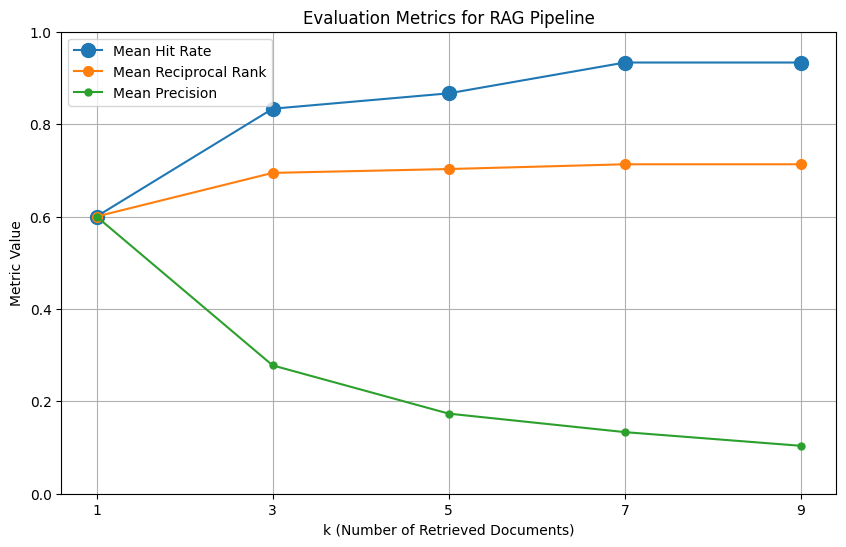

In [ ]:
# TODO: Plot the evaluation results (mean_hit_rates, mean_reciprocal_ranks, mean_precisions)
# in a line plot for different k. What do you observe?
plt.figure(figsize=(10, 6))
plt.plot(k_values, mean_hit_rates, marker='o', label='Mean Hit Rate', markersize=10)
plt.plot(k_values, mean_reciprocal_ranks, marker='o', label='Mean Reciprocal Rank', markersize=7)
plt.plot(k_values, mean_precisions, marker='o', label='Mean Precision', markersize=5)
plt.title('Evaluation Metrics for RAG Pipeline')
plt.xlabel('k (Number of Retrieved Documents)')
plt.ylabel('Metric Value')
plt.ylim(0, 1)
plt.xticks(k_values)
plt.legend()
plt.grid()
plt.show()